# Softmax GAN

##### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from time import time
import pandas as pd
import os
os.chdir('C:/Users/Nicolas/Documents/Data/Faces')
import argparse
import math
import sys
import re
import itertools
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

##### Function to sort files

In [2]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

##### Loading all file names

In [3]:
files = sorted_alphanumeric(glob('combined/*.jpg'))

In [4]:
files[:5]

['combined\\1_0_0_20161219140623097.jpg.chip.jpg',
 'combined\\1_0_0_20161219140627985.jpg.chip.jpg',
 'combined\\1_0_0_20161219140642920.jpg.chip.jpg',
 'combined\\1_0_0_20161219154018476.jpg.chip.jpg',
 'combined\\1_0_0_20161219154556757.jpg.chip.jpg']

##### Keeping all correctly formatted labels

In [5]:
np.unique([i[-34] for i in files], return_counts=True)

(array(['0', '1', '9', '_'], dtype='<U1'),
 array([12387, 11316,     1,     5], dtype=int64))

##### Removing problematic target names

In [6]:
faces = [i for i in files if (i[-34] == '1') and len(i[-37:-35].strip('\\').strip('d'))  == 2 ]

In [7]:
y = [i[-34] for i in files if (i[-34] == '1') and len(i[-37:-35].strip('\\').strip('d')) > 1 ] # MEN

In [8]:
# np.random.seed(42)
# eight_hundred = np.random.choice(faces, 800)
# pd.DataFrame(eight_hundred).to_csv('800_women.csv', header=None, index=None)

In [9]:
sex = ['men', 'women']

In [10]:
def load_women():
    faces = pd.read_csv('800_women.csv').values
    faces = faces.ravel().tolist()
    return faces
faces = load_women()

In [11]:
y = np.repeat(1, len(faces))

In [12]:
# assert len(y) == len(faces), 'The X and Y are not of the same length!'

#### This is the shape width/height

In [13]:
dim = 60

#### Cropping function

In [14]:
def crop(img):
    if img.shape[0]<img.shape[1]:
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

##### Loading and cropping images

In [15]:
print('Scaling...', end='')
start = time()
x = []
num_to_load = len(faces) 
for ix, file in enumerate(faces[:num_to_load]): 
    image = plt.imread(file, 'jpg')
    image = Image.fromarray(image).resize((dim, dim)).convert('L')
    image = crop(np.array(image))
    x.append(image)
print(f'\rDone. {int(time() - start)} seconds')

Done. 0 seconds


##### Turning the pictures into arrays

In [16]:
x = np.array(x, dtype=np.float32).reshape(-1, 1, 60, 60)
y = np.array(y, dtype=np.float32)
labels = y.copy()

##### Turning the targets into a 2D matrix

In [17]:
assert x.ndim == 4, 'The input is the wrong shape!'

In [18]:
yy, xx = y.nbytes, x.nbytes

In [19]:
print(f'The size of X is {xx:,} bytes and the size of Y is {yy:,} bytes.')

The size of X is 11,505,600 bytes and the size of Y is 3,196 bytes.


In [20]:
files, faces = None, None

##### Displaying the pictures

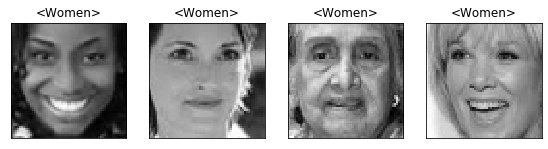

In [21]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(0, x.shape[0])
    ax = plt.imshow(x[rand][0, :, :], cmap='gray')
    plt.title('<{}>'.format(sex[int(labels[rand])].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

In [22]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=2e-1)
# x, y = None, None

In [23]:
print('Scaling...', end='')
image_size = x.shape[1] * x.shape[1] 
x = x.astype('float32') / 255 
print('\rDone.     ')

Done.     


In [24]:
if torch.cuda.is_available():
    x = torch.from_numpy(x) 
    y = torch.from_numpy(y)
    print('Tensors successfully flushed to CUDA.')
else:
    print('CUDA not available!')

Tensors successfully flushed to CUDA.


##### Making a dataset class

In [25]:
class Face():
    
    def __init__(self):
        self.len = x.shape[0]
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return x[index], y[index].unsqueeze(0)
    
    def __len__(self):
        return self.len

##### Instantiating the class

In [26]:
faces = Face()

##### The model

In [27]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=500, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=32, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0005, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=32, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=16, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=60, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=5, help="interval betwen image samples")
opt, _ = parser.parse_known_args()
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

Namespace(b1=0.5, b2=0.999, batch_size=32, channels=1, img_size=60, latent_dim=16, lr=0.0005, n_cpu=32, n_epochs=500, sample_interval=5)


In [28]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.img_size ** 2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)

        return validity

In [30]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
dataloader = torch.utils.data.DataLoader(faces,
    batch_size=opt.batch_size,
    shuffle=True,
)

In [31]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def log(x):
    return torch.log(x + 1e-8)

In [32]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits"""
    # Sample noise
    z = Variable(Tensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    gen_imgs = decoder(z)
    save_image(gen_imgs.data, "smxgan_800_women/%d.png" % batches_done, nrow=n_row, normalize=True)

In [33]:
if not os.path.isdir('smxgan'):
            os.mkdir('smxgan')

In [36]:
for epoch in range(1, opt.n_epochs + 1):
    for i, (imgs, _) in enumerate(dataloader):

        optimizer_G.zero_grad()
        optimizer_D.zero_grad()

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        g_target = 1 / (batch_size * 2)
        d_target = 1 / batch_size

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        # Generate a batch of images
        gen_imgs = generator(z)

        d_real = discriminator(real_imgs)
        d_fake = discriminator(gen_imgs)

        # Partition function
        Z = torch.sum(torch.exp(-d_real)) + torch.sum(torch.exp(-d_fake))

        # Calculate loss of discriminator and update
        d_loss = d_target * torch.sum(d_real) + log(Z)
        d_loss.backward(retain_graph=True)
        optimizer_D.step()

        # Calculate loss of generator and update
        g_loss = g_target * (torch.sum(d_real) + torch.sum(d_fake)) + log(Z)
        g_loss.backward()
        optimizer_G.step()

    batches_done = epoch * len(dataloader) + i + 1
    
    if epoch >= 150 and epoch % 25 == 0:
        val = input("\nContinue training? [y/n]: ")
        print()
        if val in ('y', 'yes'):
            val = True
            pass
        elif val in ('n', 'no'):
            break  
        else:
            pass
        
    if batches_done % opt.sample_interval == 0:
        save_image(gen_imgs.data[:25], "smxgan/%d.png" % batches_done, nrow=5, normalize=True)

    if epoch % 25 == 0:
        print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, d_loss.item(), g_loss.item())
        )

[Epoch 25/500] [D loss: 3.790434] [G loss: 4.362422]
[Epoch 50/500] [D loss: 3.883746] [G loss: 4.488559]
[Epoch 75/500] [D loss: 3.970125] [G loss: 4.479227]
[Epoch 100/500] [D loss: 3.792018] [G loss: 4.364050]
[Epoch 125/500] [D loss: 3.808454] [G loss: 4.398404]



Continue training? [y/n]:  yes



[Epoch 150/500] [D loss: 3.828728] [G loss: 4.367323]



Continue training? [y/n]:  yes



[Epoch 175/500] [D loss: 3.860184] [G loss: 4.426606]



Continue training? [y/n]:  yes



[Epoch 200/500] [D loss: 3.837776] [G loss: 4.445393]



Continue training? [y/n]:  yes



[Epoch 225/500] [D loss: 3.790248] [G loss: 4.413926]



Continue training? [y/n]:  y



[Epoch 250/500] [D loss: 3.830447] [G loss: 4.490370]



Continue training? [y/n]:  yes



[Epoch 275/500] [D loss: 3.866278] [G loss: 4.453691]



Continue training? [y/n]:  y



[Epoch 300/500] [D loss: 3.813972] [G loss: 4.406380]



Continue training? [y/n]:  no


##### Visualization

In [37]:
images = []
for file_name in sorted_alphanumeric(glob('softmax/*.png')):
    if file_name.endswith('.png'):
        file_path = os.path.join(file_name)
        images.append(file_path)

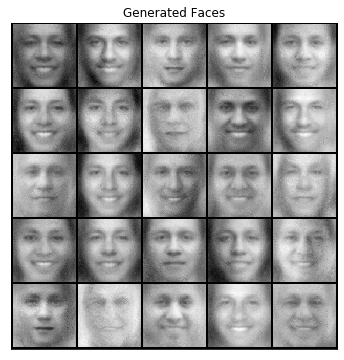

In [38]:
picture = plt.imread(images[-1])
plt.figure(figsize=(6, 6))
plt.imshow(picture)
plt.xticks([]), plt.yticks([])
plt.title('Generated Faces')
plt.show()

#### Generating 25,000 pictures

In [43]:
images = 0
if not os.path.isdir('smxgan_800_women'):
            os.mkdir('smxgan_800_women')

for epoch in range(1, 50 + 1): 
    for i, (imgs, _) in enumerate(dataloader):
        
        with torch.no_grad():

            # Adversarial ground truths
            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            batches_done = epoch * len(dataloader) + i
            save_image(gen_imgs.data[:25], "smxgan_800_women/%d.png" % batches_done, nrow=5, normalize=True)
            images += 25
            
    if images % 5_000 == 0:
        print(f'Pictures created: {images:,}')
        
    if len(os.listdir(os.path.join(os.getcwd(), 'smxgan_800_women')))  >= 1_000:
        print('\n25,000 images successfully generated.')
        break

Pictures created: 5,000
Pictures created: 10,000
Pictures created: 15,000
Pictures created: 20,000
Pictures created: 25,000

25,000 images successfully generated.
